# 03 - Bayesian Hierarchical Modeling

Fit hierarchical model to 911 prices, diagnose, visualize, and predict.

**Inputs:**
- `data/processed/cleaned_listings.parquet`

**Model:**
```
log(price) ~ age + mileage + 
             (1 + age | generation) +  # random intercept + slope
             (1 | trim_tier) +         # collapsed: base, sport, gt, turbo
             (1 | transmission)
```

**Fixes for convergence:**
1. Weakly informative priors on random effect SDs (HalfNormal σ=0.3-0.5)
2. Trim collapsed into 4 tiers (sparse individual levels)
3. Higher target_accept (0.95)

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from price_analysis.constants import WATER_COOLED_GENS
from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import build_model, fit_model, predict_price
from price_analysis.models.hierarchical import (
    DEFAULT_PRIORS,
    check_diagnostics,
    extract_effects,
    format_prediction_summary,
    plot_model_graph,
)
from price_analysis.visualization import (
    plot_cost_per_mile,
    plot_dollar_premiums,
    plot_prior_posterior,
    plot_shrinkage_comparison,
    plot_shrinkage_regression,
)

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Paths
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

# Scaling parameters for prediction
MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(
    f"Model data: {len(df)} listings | Mileage scaling: μ={MILEAGE_MEAN:.0f}, σ={MILEAGE_STD:.0f}"
)
print(f"Trim tiers: {df['trim_tier'].value_counts().to_dict()}")
print(f"Trans types: {df['trans_type'].value_counts().to_dict()}")

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings | Mileage scaling: μ=40129, σ=38335
Trim tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
Trans types: {'manual': 790, 'pdk': 476, 'auto': 94}


In [4]:
# Model configuration
INCLUDE_SALE_YEAR = False  # Currently all 2025 listings (no variance)
USE_TRIM_TIER = True  # Collapse trims into 4 performance tiers
USE_TRANS_TYPE = True  # Collapse Auto/Tiptronic into 'auto'
TARGET_ACCEPT = 0.975  # Higher acceptance rate to reduce divergences

# Show default priors (can override with custom dict)
print("Default priors:")
for k, v in DEFAULT_PRIORS.items():
    print(f"  {k}: {v}")

Default priors:
  intercept_mu: 11.5
  intercept_sigma: 1.0
  sigma_lam: 3.0
  generation_sd: 0.5
  trim_sd: 0.7
  transmission_sd: 0.3
  body_style_sd: 0.3
  color_category_sd: 0.3
  age_slope_sd: 0.1
  age_sigma: 0.05
  mileage_sigma: 0.2
  low_mileage_sigma: 0.2
  log_mileage_sigma: 0.3


In [5]:
# Primary model: random intercept + slope on age by generation
# Different generations depreciate at different rates (992.1 vs air-cooled)
model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,  # Random slope on age per generation
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
)
print(model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            age ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.2)
            is_low_mileage ~ <function _truncated_normal_lower at 0x309c3c860>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(

## Prior Predictive Checks

Before fitting, sample from the prior predictive distribution to verify our priors produce reasonable price predictions.

In [6]:
# Sample from prior predictive distribution
model.build()
prior_idata = model.prior_predictive(draws=500, random_seed=42)

Sampling: [1|body_style_offset, 1|body_style_sigma, 1|generation_offset, 1|generation_sigma, 1|trans_type_offset, 1|trans_type_sigma, 1|trim_tier_offset, 1|trim_tier_sigma, Intercept, age, age|generation_offset, age|generation_sigma, is_low_mileage, log_price, mileage_scaled, sigma]
INFO:pymc.sampling.forward:Sampling: [1|body_style_offset, 1|body_style_sigma, 1|generation_offset, 1|generation_sigma, 1|trans_type_offset, 1|trans_type_sigma, 1|trim_tier_offset, 1|trim_tier_sigma, Intercept, age, age|generation_offset, age|generation_sigma, is_low_mileage, log_price, mileage_scaled, sigma]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3530620634.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


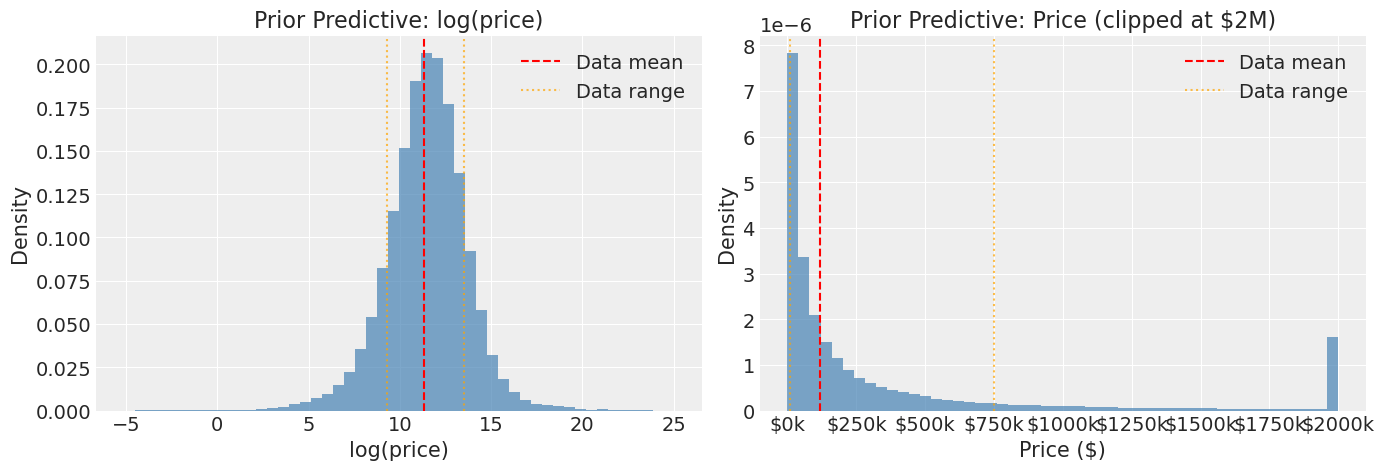

Prior log-price: mean=11.46, std=2.24
Prior log-price range: [-5.12, 25.05]
Data log-price range: [9.28, 13.53]

Prior price (clipped): median=$103,378
% of prior samples > $2M: 6.3%


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prior predictive log-price distribution
y_prior = prior_idata.prior_predictive["log_price"].values.flatten()
axes[0].hist(y_prior, bins=50, alpha=0.7, density=True, color="steelblue")
axes[0].axvline(df["log_price"].mean(), color="red", linestyle="--", label="Data mean")
axes[0].axvline(df["log_price"].min(), color="orange", linestyle=":", alpha=0.7, label="Data range")
axes[0].axvline(df["log_price"].max(), color="orange", linestyle=":", alpha=0.7)
axes[0].set_xlabel("log(price)")
axes[0].set_ylabel("Density")
axes[0].set_title("Prior Predictive: log(price)")
axes[0].legend()

# Prior predictive price distribution (clip extreme values for visualization)
price_prior = np.exp(y_prior)
price_prior_clipped = np.clip(price_prior, 0, 2_000_000)  # Clip at $2M
axes[1].hist(price_prior_clipped, bins=50, alpha=0.7, density=True, color="steelblue")
axes[1].axvline(df["sale_price"].mean(), color="red", linestyle="--", label="Data mean")
axes[1].axvline(
    df["sale_price"].min(), color="orange", linestyle=":", alpha=0.7, label="Data range"
)
axes[1].axvline(df["sale_price"].max(), color="orange", linestyle=":", alpha=0.7)
axes[1].set_xlabel("Price ($)")
axes[1].set_ylabel("Density")
axes[1].set_title("Prior Predictive: Price (clipped at $2M)")
axes[1].legend()
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x / 1000:.0f}k"))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Prior log-price: mean={y_prior.mean():.2f}, std={y_prior.std():.2f}")
print(f"Prior log-price range: [{y_prior.min():.2f}, {y_prior.max():.2f}]")
print(f"Data log-price range: [{df['log_price'].min():.2f}, {df['log_price'].max():.2f}]")
print(f"\nPrior price (clipped): median=${np.median(price_prior_clipped):,.0f}")
print(f"% of prior samples > $2M: {(price_prior > 2_000_000).mean() * 100:.1f}%")

too many high value in prior clipped at 2m$ imo, not crazily so but should adjust prob

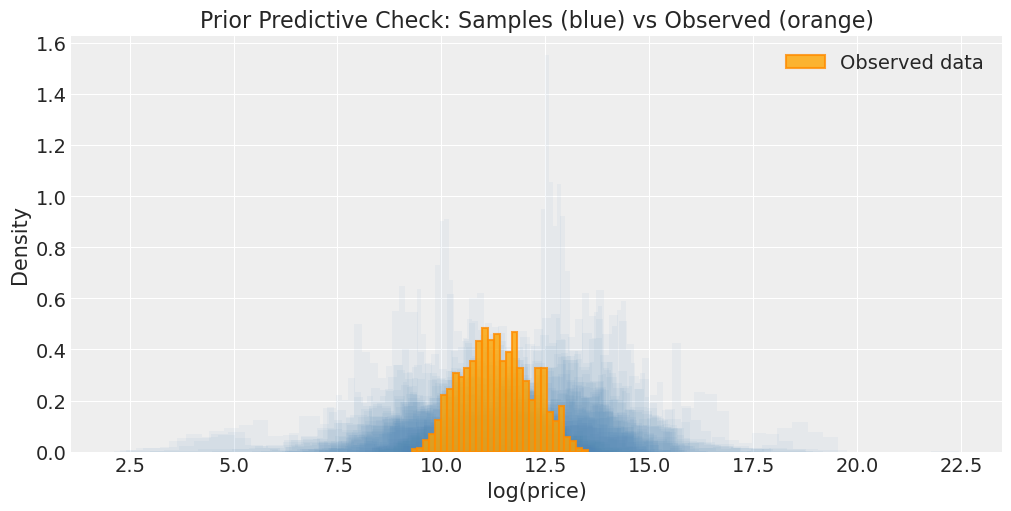

In [8]:
# PPC-style plot: prior predictive samples vs observed data
fig, ax = plt.subplots(figsize=(10, 5))

# Plot prior predictive draws (thin lines)
y_prior_2d = prior_idata.prior_predictive["log_price"].values  # (chain, draw, obs)
for i in range(min(50, y_prior_2d.shape[1])):  # Plot up to 50 draws
    ax.hist(y_prior_2d[0, i, :], bins=30, alpha=0.05, color="steelblue", density=True)

# Overlay observed data
ax.hist(
    df["log_price"],
    bins=30,
    alpha=0.8,
    color="orange",
    density=True,
    label="Observed data",
    edgecolor="darkorange",
    linewidth=1.5,
)

ax.set_xlabel("log(price)")
ax.set_ylabel("Density")
ax.set_title("Prior Predictive Check: Samples (blue) vs Observed (orange)")
ax.legend()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/341106386.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


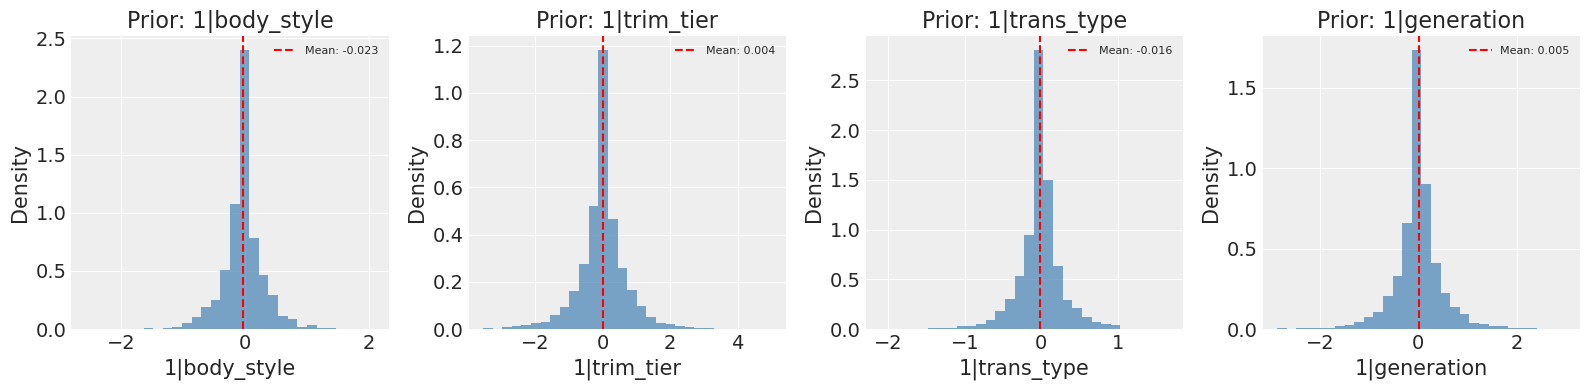

In [9]:
# Visualize prior distributions for random effect standard deviations
re_vars = [v for v in prior_idata.prior.data_vars if "_sigma" in v or "1|" in v]
if re_vars:
    n_vars = len(re_vars)
    fig, axes = plt.subplots(1, min(n_vars, 4), figsize=(4 * min(n_vars, 4), 4))
    if n_vars == 1:
        axes = [axes]

    for ax, var in zip(axes, re_vars[:4]):
        samples = prior_idata.prior[var].values.flatten()
        ax.hist(samples, bins=30, alpha=0.7, color="steelblue", density=True)
        ax.axvline(samples.mean(), color="red", linestyle="--", label=f"Mean: {samples.mean():.3f}")
        ax.set_xlabel(var)
        ax.set_ylabel("Density")
        ax.set_title(f"Prior: {var}")
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("No random effect variance parameters found in prior samples")

**Interpretation:**
- **Overlay plot:** Blue histograms show individual prior predictive draws; orange shows observed data. Good priors should have draws that "cover" the observed distribution without being wildly diffuse.
- **Random effects:** The σ parameters control how much variation each grouping factor explains. Very large σ priors may dominate; very small may underfit group differences.

If the priors seem too diffuse or too tight, adjust `DEFAULT_PRIORS` in `src/price_analysis/models/hierarchical.py`.

In [10]:
# Fit primary model (this may take a few minutes)
idata = fit_model(
    model,
    draws=1000,
    tune=1000,
    chains=9,
    cores=9,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 9 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (9 chains in 9 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (9 chains in 9 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 110 seconds.
INFO:pymc.sampling.mcmc:Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 110 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma            0.200  0.004   0.193    0.208      0.000    0.000   16504.0   
Intercept       11.864  0.290  11.315   12.422      0.005    0.004    3443.0   
age             -0.027  0.009  -0.044   -0.009      0.000    0.000    2878.0   
mileage_scaled  -0.214  0.008  -0.229   -0.198      0.000    0.000   18768.0   
is_low_mileage   0.165  0.021   0.124    0.202      0.000    0.000   12213.0   

                ess_tail  r_hat  
sigma             6045.0    1.0  
Intercept         4862.0    1.0  
age               2233.0    1.0  
mileage_scaled    6342.0    1.0  
is_low_mileage    5965.0    1.0  


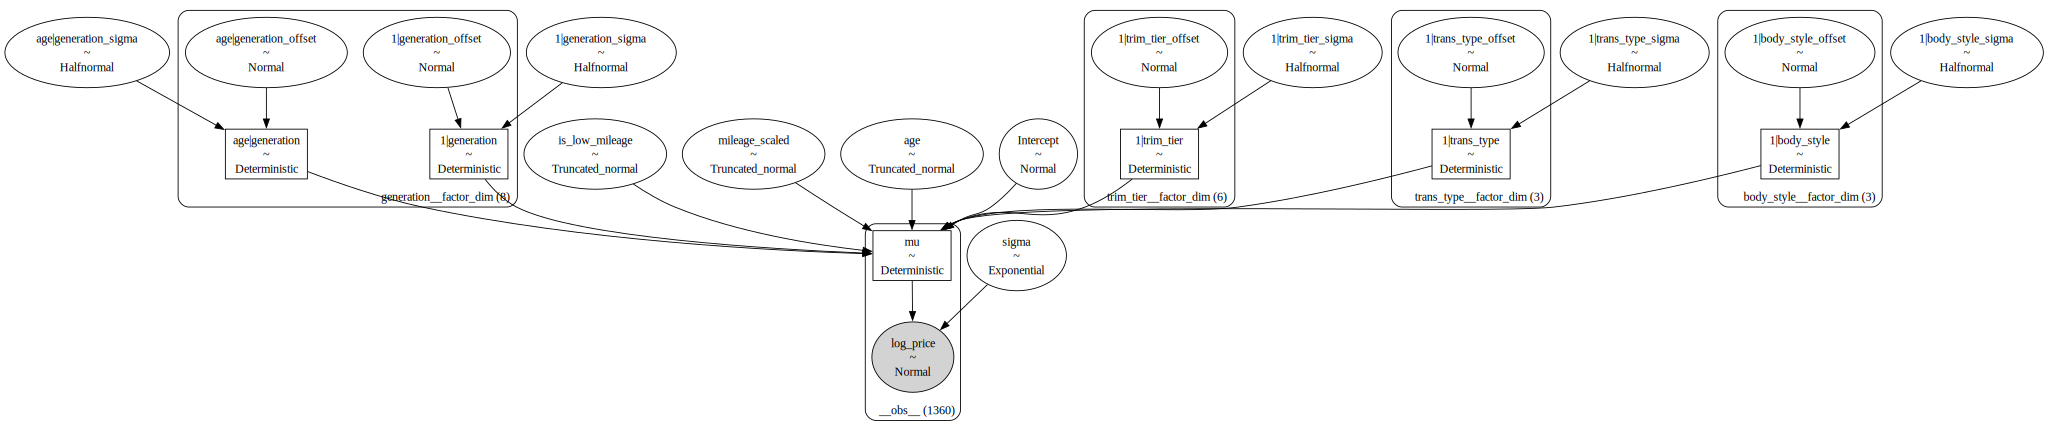

In [11]:
# Display model DAG
graph = plot_model_graph(model)
display(graph)

## Model Comparison: With vs Without Age Slopes by Generation

For reference, we also fit a simpler model without random slopes on age.
LOO-CV comparison shows the slope model performs better (captures different depreciation rates).

In [12]:
# Simple model for comparison: intercept-only for generation (no varying slopes)
model_simple = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=False,  # No random slope on age
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
)
print(model_simple)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            age ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.2)
            is_low_mileage ~ <function _truncated_normal_lower at 0x309c3c860>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ Exponential

In [13]:
# Fit simple model for comparison
idata_simple = fit_model(
    model_simple,
    draws=1000,
    tune=1000,
    chains=9,
    cores=9,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 9 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (9 chains in 9 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (9 chains in 9 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 100 seconds.
INFO:pymc.sampling.mcmc:Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 100 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma            0.202  0.004   0.194    0.209      0.000    0.000   14297.0   
Intercept       11.832  0.302  11.266   12.404      0.005    0.003    3562.0   
age             -0.030  0.007  -0.043   -0.017      0.000    0.000    2315.0   
mileage_scaled  -0.217  0.008  -0.232   -0.201      0.000    0.000   16469.0   
is_low_mileage   0.151  0.020   0.113    0.189      0.000    0.000   13758.0   

                ess_t

In [14]:
# Compare models via PSIS-LOO
# (log_likelihood computed during fitting via idata_kwargs)
comparison = az.compare(
    {"with_age_slope": idata, "intercept_only": idata_simple},
    ic="loo",
    scale="log",
)
display(comparison.round(4))

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_age_slope,0,243.1121,27.0577,0.0000,1.0,50.5694,0.0000,False,log
intercept_only,1,235.7723,25.6930,7.3397,0.0,50.3194,2.6163,False,log


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/323549480.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


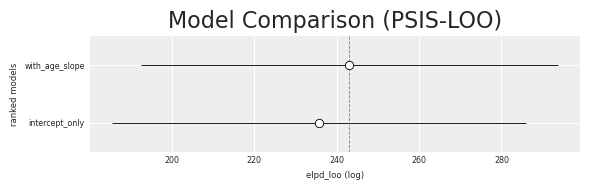

In [15]:
# Visualize model comparison
az.plot_compare(comparison)
plt.title("Model Comparison (PSIS-LOO)")
plt.tight_layout()
plt.show()

In [16]:
# Compare diagnostics
diag_with_slope = check_diagnostics(idata)
diag_simple = check_diagnostics(idata_simple)

print("Model with age slope:")
print(f"  Divergences: {diag_with_slope['n_divergences']}")
print(f"  Max R-hat: {diag_with_slope['rhat_max']:.4f}")
print(f"  Min ESS (bulk): {diag_with_slope['ess_bulk_min']:.0f}")

print("\nSimple model (intercept only):")
print(f"  Divergences: {diag_simple['n_divergences']}")
print(f"  Max R-hat: {diag_simple['rhat_max']:.4f}")
print(f"  Min ESS (bulk): {diag_simple['ess_bulk_min']:.0f}")

Model with age slope:
  Divergences: 0
  Max R-hat: 1.0000
  Min ESS (bulk): 2435

Simple model (intercept only):
  Divergences: 0
  Max R-hat: 1.0000
  Min ESS (bulk): 1810


### Interpretation

**LOO-CV comparison:**
- Higher ELPD = better out-of-sample predictive performance
- If difference < 1 SE, models are practically equivalent → prefer simpler
- `p_loo` = effective number of parameters (complexity penalty)

**Decision rule:** If `intercept_only` ELPD is within ~1 SE of `with_age_slope`, drop the random slope.

## MCMC Diagnostics

Check for convergence issues before interpreting results.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3320152081.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


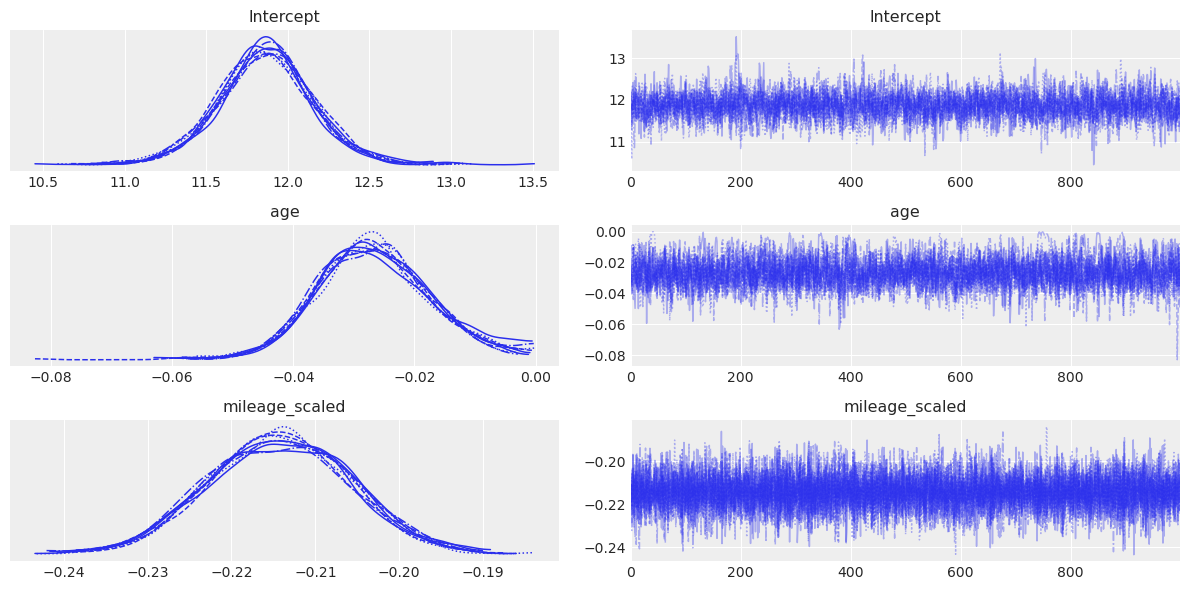

In [17]:
# Trace plots for fixed effects
var_names = ["Intercept", "age", "mileage_scaled"]
if INCLUDE_SALE_YEAR:
    var_names.append("sale_year")
az.plot_trace(idata, var_names=var_names)
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3564994746.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


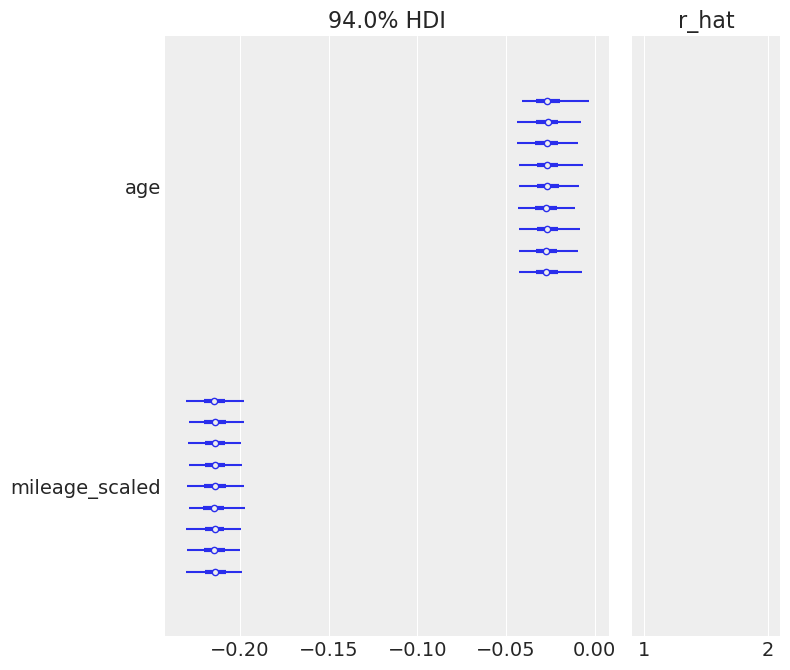

In [18]:
# R-hat summary
az.plot_forest(idata, var_names=["age", "mileage_scaled"], r_hat=True)
plt.tight_layout()
plt.show()

In [19]:
summary = az.summary(idata, var_names=var_names, hdi_prob=0.95)
display(summary)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,11.864,0.290,11.287,12.448,0.005,0.004,3443.0,4862.0,1.0
age,-0.027,0.009,-0.044,-0.007,0.000,0.000,2878.0,2233.0,1.0
mileage_scaled,-0.214,0.008,-0.231,-0.198,0.000,0.000,18768.0,6342.0,1.0


**Interpretation (coefficients are on log-price scale):**

- `age`: Expected change in log(price) per year of age (negative = depreciation)
- `mileage_scaled`: Effect of 1 SD increase in mileage
- `sale_year`: Market trend (positive = prices rising over time) — *excluded when constant*

## Random Effects

Visualize generation, trim, and transmission effects.

In [20]:
effects = extract_effects(idata)

print("Fixed effects:")
for name, vals in effects["fixed"].items():
    print(f"  {name}: {vals['mean']:.3f} [{vals['hdi_90'][0]:.3f}, {vals['hdi_90'][1]:.3f}]")

Fixed effects:
  Intercept: 11.864 [11.390, 12.335]
  age: -0.027 [-0.043, -0.012]
  mileage_scaled: -0.214 [-0.228, -0.201]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/1072741184.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


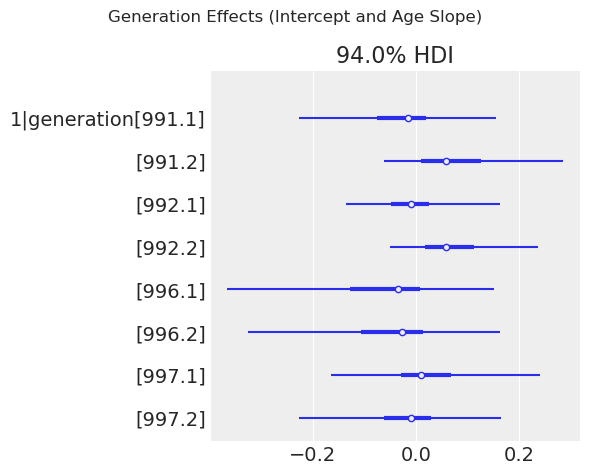

In [21]:
# Forest plot of generation effects
az.plot_forest(idata, var_names=["1|generation"], combined=True)
plt.suptitle("Generation Effects (Intercept and Age Slope)")
plt.tight_layout()
plt.show()

# , "age|generation"  # we rm'ed this effect, no real age x gen effect

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/1161933721.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


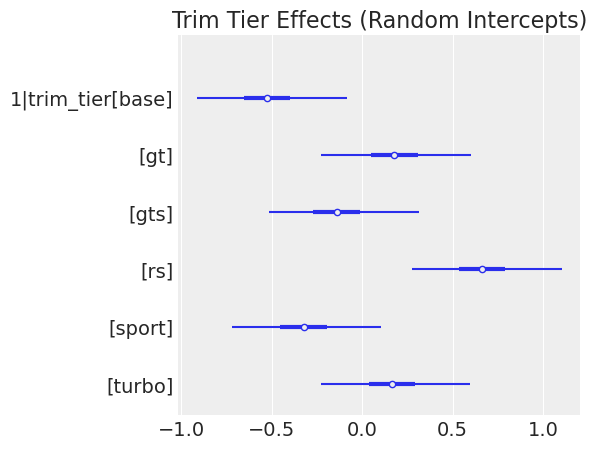

In [22]:
# Forest plot of trim tier effects
az.plot_forest(idata, var_names=["1|trim_tier"], combined=True)
plt.title("Trim Tier Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/1451782903.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


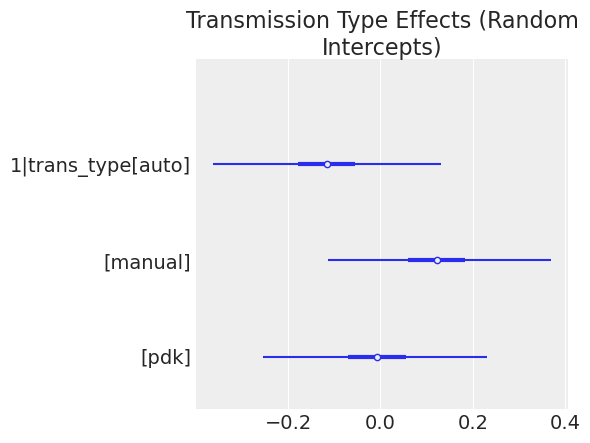

In [23]:
# Forest plot of transmission type effects
az.plot_forest(idata, var_names=["1|trans_type"], combined=True)
plt.title("Transmission Type Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

## Posterior Predictive Checks

How well does the model reproduce the observed data?

In [24]:
# Generate posterior predictive samples
model.predict(idata, kind="response", inplace=True)

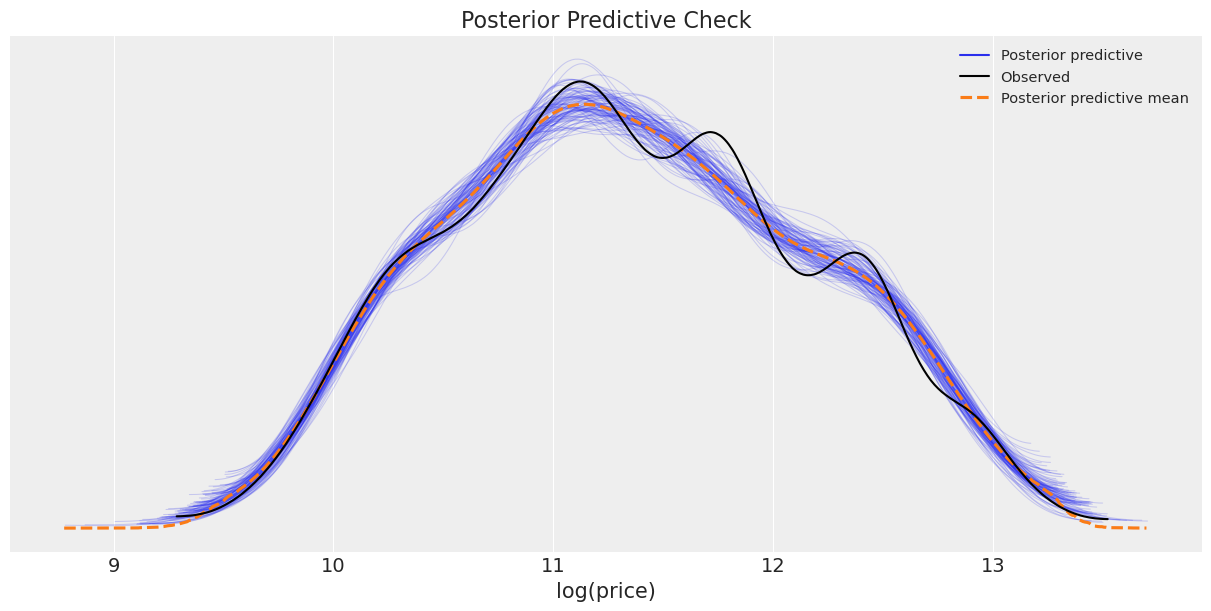

In [25]:
az.plot_ppc(idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlabel("log(price)")
# plt.tight_layout()
plt.show()

## Price Predictions

Predict prices for specific configurations.

In [26]:
# Example estimate of price
pred = predict_price(
    model=model,
    idata=idata,
    df=df,
    generation="996.2",
    trim_tier="sport",
    trans_type="manual",
    body_style="coupe",
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

display(format_prediction_summary(pred))

'Price prediction for:\n  2002 996.2 sport (manual)\n  Mileage: 45,000 miles\n  Sale year: 2025 (age: 23 years)\n\nPredicted price:\n  Median: $45,174\n  Mean:   $46,052\n  80% CI: $34,958 - $58,275\n  95% CI: $30,455 - $66,983'

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3154495474.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


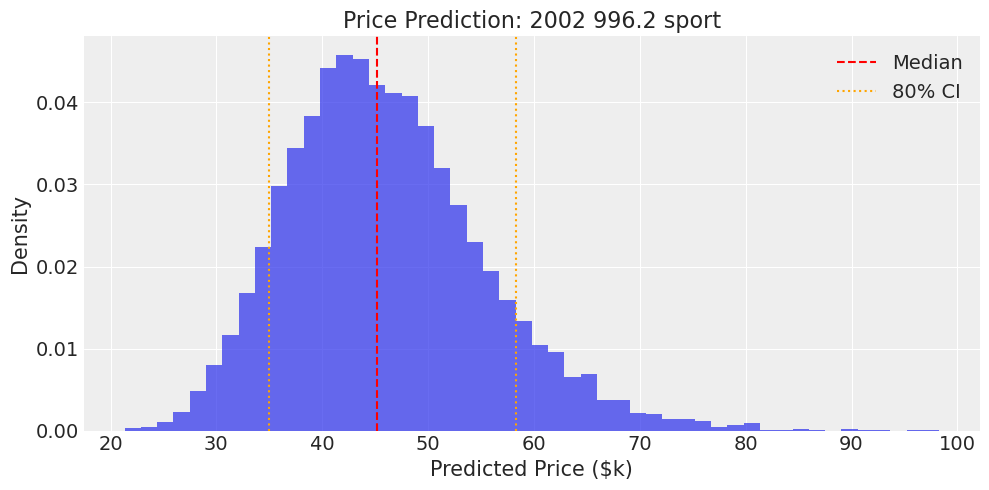

In [27]:
# Visualize prediction distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(pred["samples"] / 1000, bins=50, alpha=0.7, density=True)
ax.axvline(pred["price"]["median"] / 1000, color="red", linestyle="--", label="Median")
ax.axvline(pred["price"]["ci_80"][0] / 1000, color="orange", linestyle=":", label="80% CI")
ax.axvline(pred["price"]["ci_80"][1] / 1000, color="orange", linestyle=":")
ax.set_xlabel("Predicted Price ($k)")
ax.set_ylabel("Density")
ax.set_title(
    f"Price Prediction: {pred['config']['model_year']} {pred['config']['generation']} {pred['config']['trim_tier']}"
)
ax.legend()
plt.tight_layout()
plt.show()

In [28]:
# Compare: Same car but different generation
pred_992 = predict_price(
    model=model,
    idata=idata,
    df=df,
    generation="992.1",
    trim_tier="sport",
    trans_type="pdk",
    body_style="coupe",
    model_year=2022,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

print("996.2 vs 992.1 Carrera 4S comparison:")
print(f"  996.2 (2002, 45k mi, Manual): ${pred['price']['median']:,.0f}")
print(f"  992.1 (2022, 45k mi, PDK):    ${pred_992['price']['median']:,.0f}")

996.2 vs 992.1 Carrera 4S comparison:
  996.2 (2002, 45k mi, Manual): $45,174
  992.1 (2022, 45k mi, PDK):    $102,418


## Depreciation Curves by Generation

Project price trajectories over time.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/1454975910.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


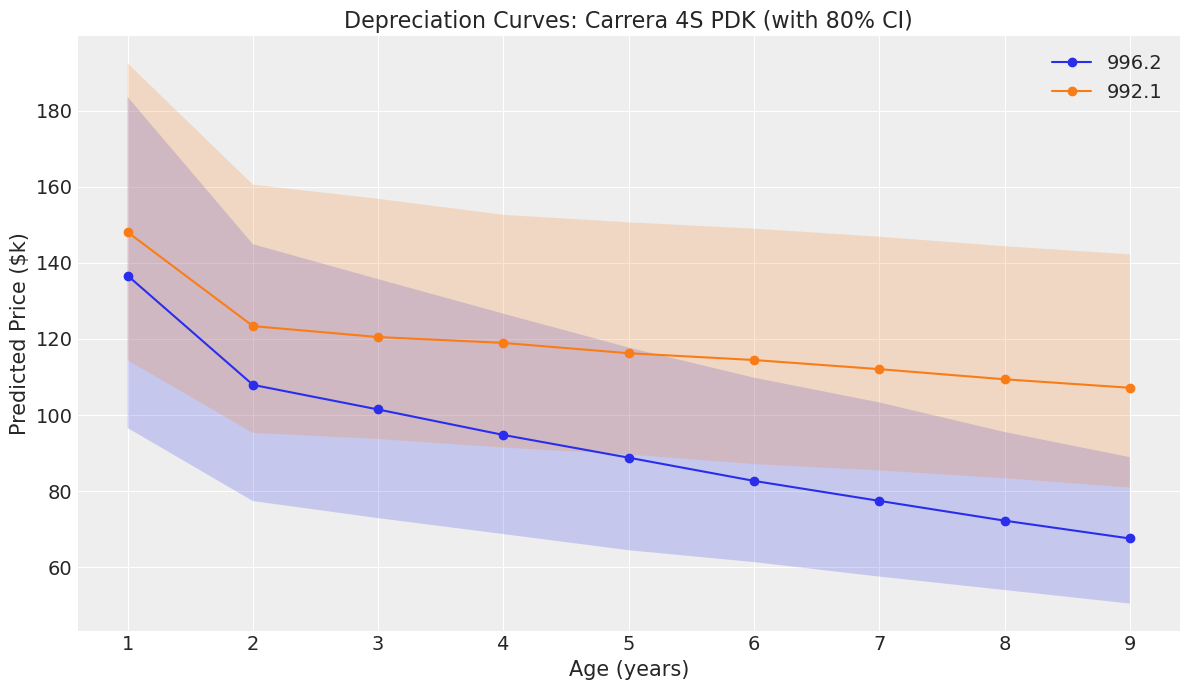

In [29]:
# Project prices for different generations over time
generations = ["996.2", "992.1"]
ages = range(1, 10)
base_year = 2020  # Approximate mid-point for 992.1

fig, ax = plt.subplots(figsize=(12, 7))

for gen in generations:
    medians = []
    ci_lows = []
    ci_highs = []

    for age in ages:
        pred_dep = predict_price(
            model=model,
            idata=idata,
            df=df,
            generation=gen,
            trim_tier="sport",
            trans_type="pdk",
            body_style="coupe",
            model_year=base_year,
            mileage=5000 * age,  # Assume 5k miles/year
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_dep["price"]["median"])
        ci_lows.append(pred_dep["price"]["ci_80"][0])
        ci_highs.append(pred_dep["price"]["ci_80"][1])

    ax.plot(list(ages), [m / 1000 for m in medians], label=gen, marker="o")
    ax.fill_between(
        list(ages),
        [l / 1000 for l in ci_lows],
        [h / 1000 for h in ci_highs],
        alpha=0.2,
    )

ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title("Depreciation Curves: Carrera 4S PDK (with 80% CI)")
ax.legend()
plt.tight_layout()
plt.show()

## Pure Age Depreciation (Mileage Held Constant at 40k)

How does price decline purely with calendar time, independent of miles driven?

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/1910803842.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


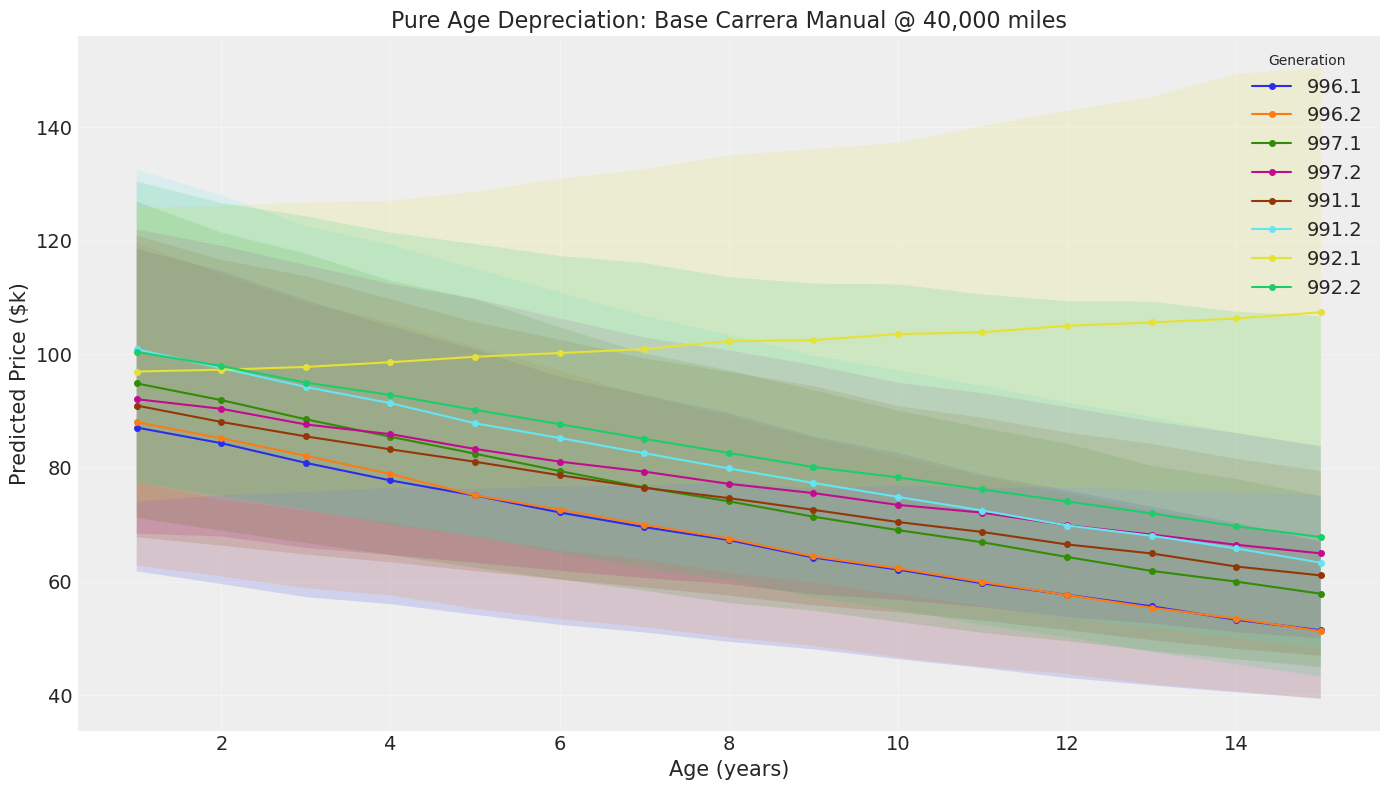


Average annual depreciation: 2.6% per year


In [30]:
# Pure age depreciation: hold mileage constant at 40k, vary age
# This isolates "calendar depreciation" from wear-based depreciation

FIXED_MILEAGE = 40000
ages = range(1, 16)

fig, ax = plt.subplots(figsize=(14, 8))

for gen in WATER_COOLED_GENS:
    medians = []
    ci_lows = []
    ci_highs = []

    for age in ages:
        pred_age = predict_price(
            model=model,
            idata=idata,
            df=df,
            generation=gen,
            trim_tier="base",
            trans_type="manual",
            body_style="coupe",
            model_year=2025 - age,
            mileage=FIXED_MILEAGE,
            sale_year=2025,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_age["price"]["median"])
        ci_lows.append(pred_age["price"]["ci_80"][0])
        ci_highs.append(pred_age["price"]["ci_80"][1])

    ax.plot(list(ages), [m / 1000 for m in medians], label=gen, marker="o", markersize=4)
    ax.fill_between(
        list(ages),
        [lo / 1000 for lo in ci_lows],
        [hi / 1000 for hi in ci_highs],
        alpha=0.15,
    )

ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title(f"Pure Age Depreciation: Base Carrera Manual @ {FIXED_MILEAGE:,} miles")
ax.legend(title="Generation", loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate annual depreciation rate from age coefficient
age_coef = idata.posterior["age"].mean().item()
annual_depreciation_pct = (1 - np.exp(age_coef)) * 100
print(f"\nAverage annual depreciation: {annual_depreciation_pct:.1f}% per year")

## Pure Mileage Depreciation (Age Held Constant at 5 Years)

How does price decline purely with miles driven, independent of calendar time?

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3415911858.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


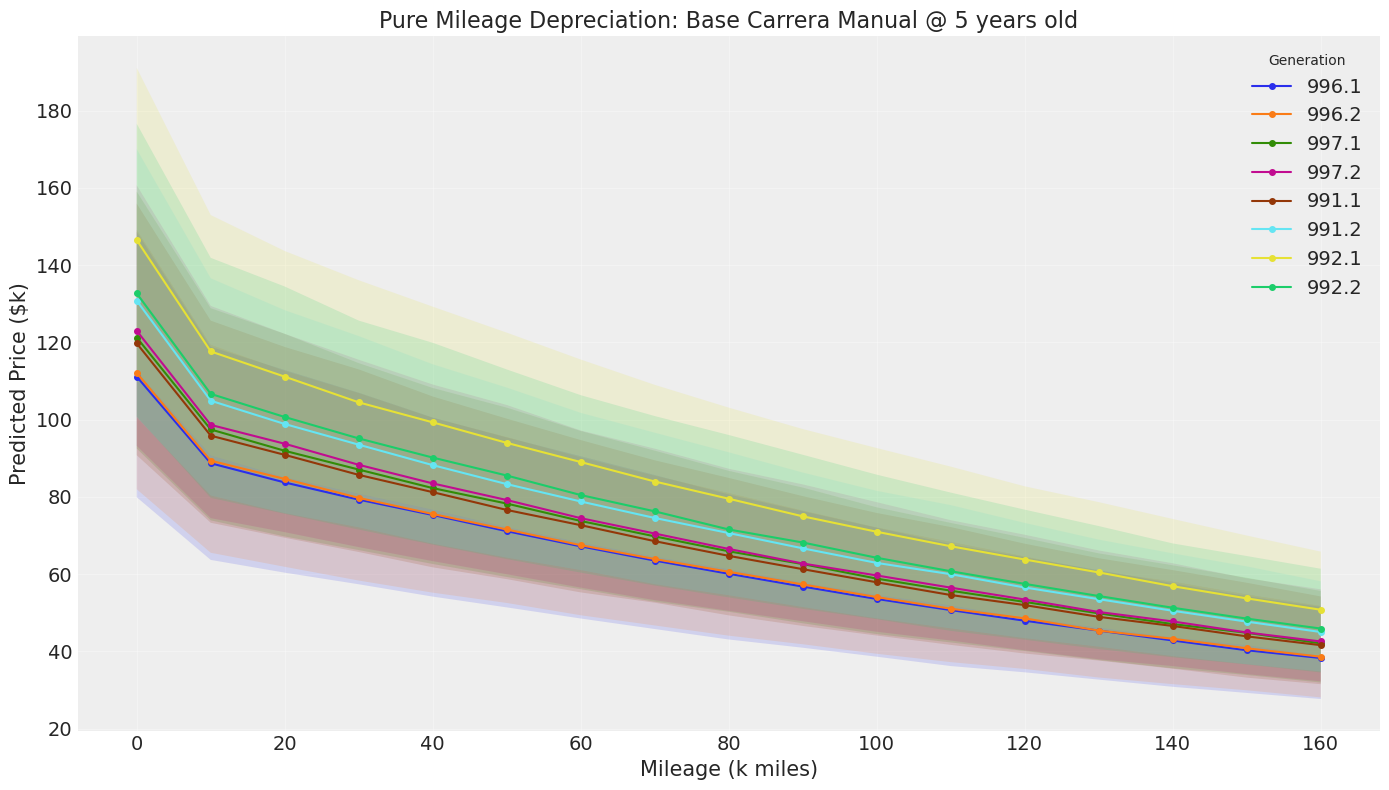

In [31]:
# Pure mileage depreciation: hold age constant at 5 years, vary mileage
# This isolates "wear depreciation" from calendar-based depreciation

FIXED_AGE = 5
mileages = np.arange(0, 160001, 10000)  # 0 to 160k in 10k increments

fig, ax = plt.subplots(figsize=(14, 8))

for gen in WATER_COOLED_GENS:
    medians = []
    ci_lows = []
    ci_highs = []

    for mileage in mileages:
        pred_mi = predict_price(
            model=model,
            idata=idata,
            df=df,
            generation=gen,
            trim_tier="base",
            trans_type="manual",
            body_style="coupe",
            model_year=2025 - FIXED_AGE,
            mileage=int(mileage),
            sale_year=2025,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_mi["price"]["median"])
        ci_lows.append(pred_mi["price"]["ci_80"][0])
        ci_highs.append(pred_mi["price"]["ci_80"][1])

    ax.plot(mileages / 1000, [m / 1000 for m in medians], label=gen, marker="o", markersize=4)
    ax.fill_between(
        mileages / 1000,
        [lo / 1000 for lo in ci_lows],
        [hi / 1000 for hi in ci_highs],
        alpha=0.15,
    )

ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title(f"Pure Mileage Depreciation: Base Carrera Manual @ {FIXED_AGE} years old")
ax.legend(title="Generation", loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cost-per-Mile Analysis

How much does each mile cost in depreciation? The mileage coefficient is on log-price scale,
so the $/mile varies with car value - more expensive cars lose more dollars per mile.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:371: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


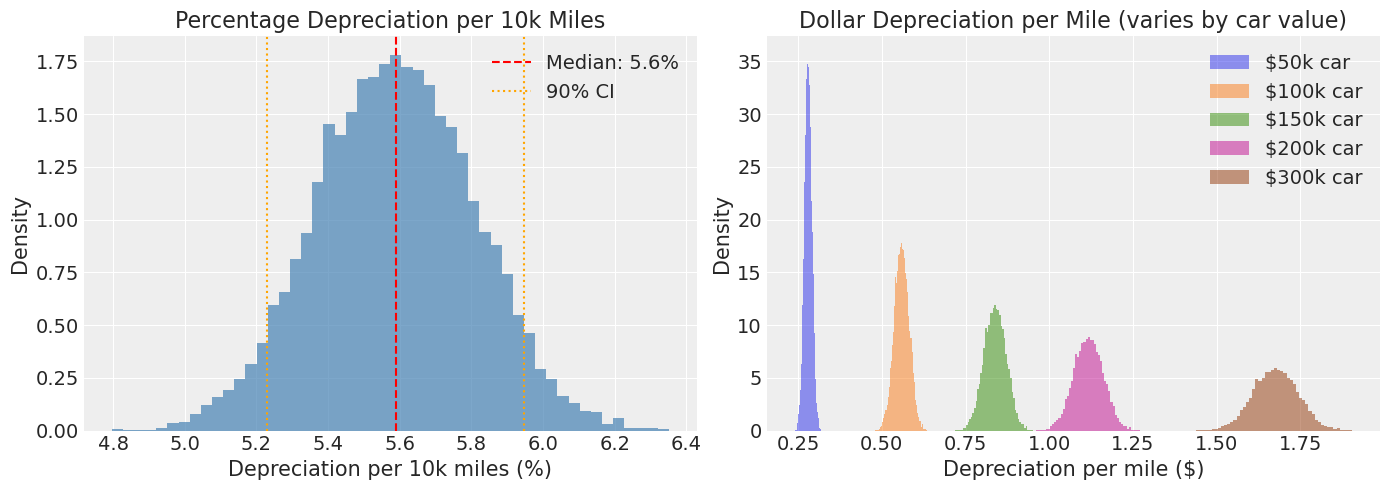

Cost-per-Mile Summary:
  Percentage per mile: 0.0006%
  Percentage per 10k miles: 5.6% [5.2%, 5.9%]


In [32]:
fig = plot_cost_per_mile(idata, MILEAGE_STD)
plt.show()

# Summary stats
mileage_coef_samples = idata.posterior["mileage_scaled"].values.flatten()
pct_per_mile = (1 - np.exp(mileage_coef_samples / MILEAGE_STD)) * 100
pct_per_10k = pct_per_mile * 10000
print("Cost-per-Mile Summary:")
print(f"  Percentage per mile: {np.median(pct_per_mile):.4f}%")
print(
    f"  Percentage per 10k miles: {np.median(pct_per_10k):.1f}% [{np.percentile(pct_per_10k, 5):.1f}%, {np.percentile(pct_per_10k, 95):.1f}%]"
)

## Shrinkage Plot (Partial Pooling Visualization)

Hierarchical models "shrink" group estimates toward the grand mean, especially for groups with
less data. This plot compares raw group means (unpooled) with hierarchical estimates (partial pooling).

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_means = df.groupby(col)["log_price"].mean()
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:217: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(col).size()
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

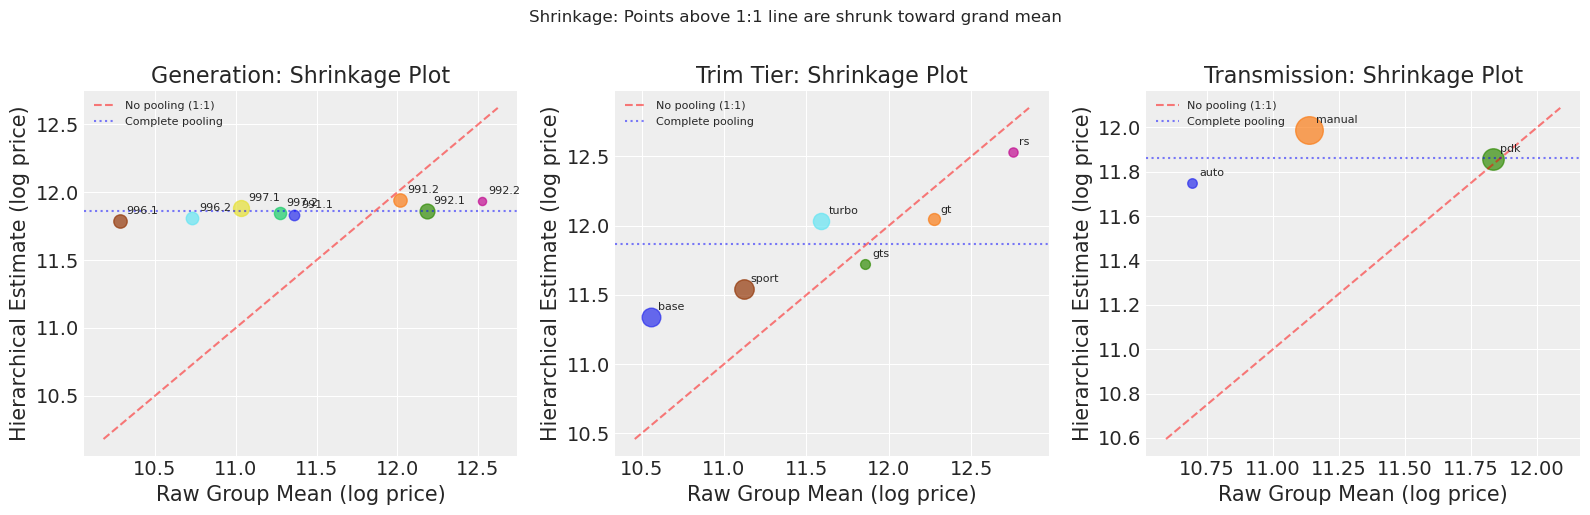

Interpretation: Points close to the 1:1 line have little shrinkage (large groups).
Points pulled toward the blue line are shrunk more (smaller groups or extreme values).


In [33]:
fig = plot_shrinkage_comparison(df, idata)
plt.show()

print("Interpretation: Points close to the 1:1 line have little shrinkage (large groups).")
print("Points pulled toward the blue line are shrunk more (smaller groups or extreme values).")

## Shrinkage on Regression Lines

Compares unpooled OLS (dashed) vs hierarchical (solid) fits per generation.
Sparse generations show more shrinkage toward the global trend.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gen_counts = df.groupby("generation").size().sort_values()
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:91: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


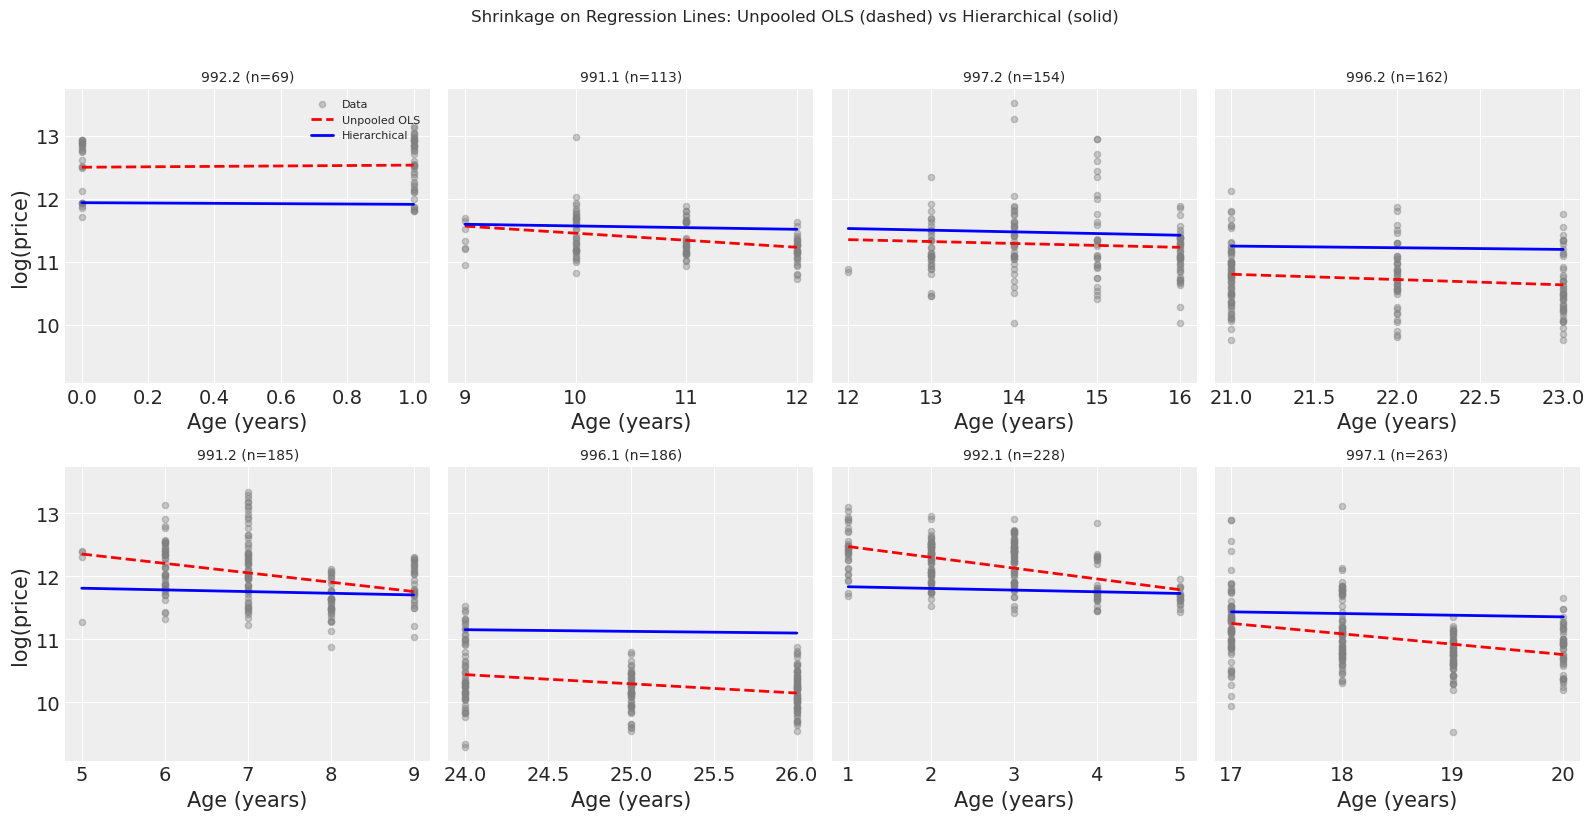

,n,ols_intercept,hier_intercept,shrinkage
generation,,,,
992.2,69,12.500864,11.937473,-0.563392
991.1,113,12.573054,11.834197,-0.738857
997.2,154,11.717551,11.846787,0.129236
996.2,162,12.569599,11.807931,-0.761667
991.2,185,13.099014,11.942983,-1.156032
996.1,186,13.958009,11.790546,-2.167463
992.1,228,12.643123,11.859632,-0.783490
997.1,263,14.050512,11.887331,-2.163181


In [34]:
fig, shrinkage_df = plot_shrinkage_regression(df, idata)
plt.show()
display(shrinkage_df.set_index("generation"))

## Prior vs Posterior Comparison

Shows how the data updated our prior beliefs. Narrower, shifted posteriors = informative data.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:183: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


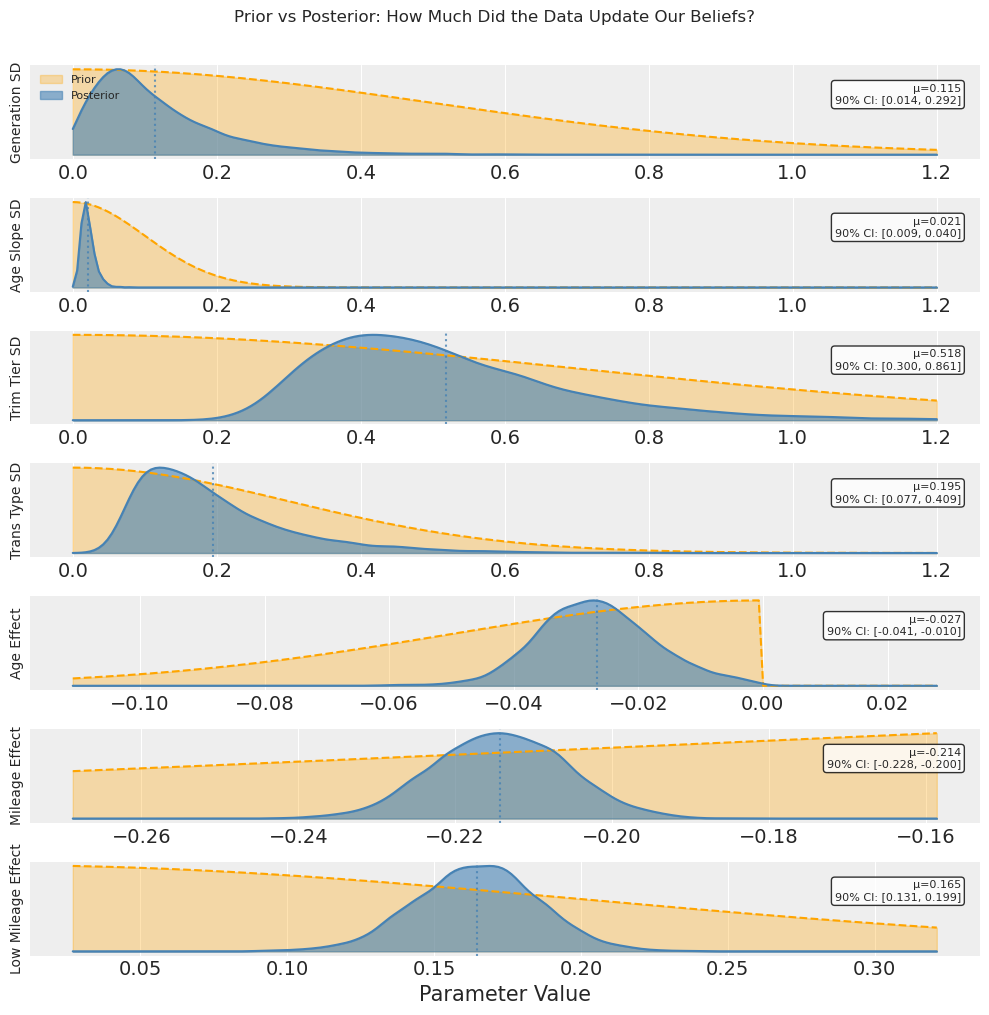

In [35]:
fig = plot_prior_posterior(idata)
plt.show()

## Dollar-Denominated Premiums

Convert random effects from log-scale to dollar amounts. Since effects are multiplicative,
we show premiums for a reference car (median price ~$80k).

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:428: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


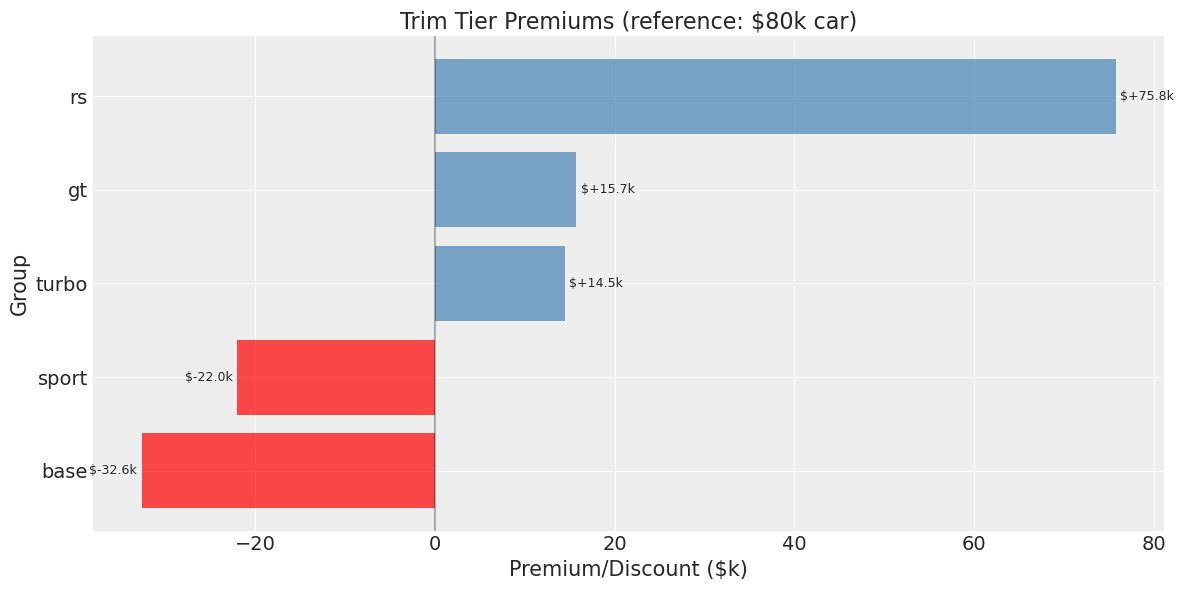

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:428: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


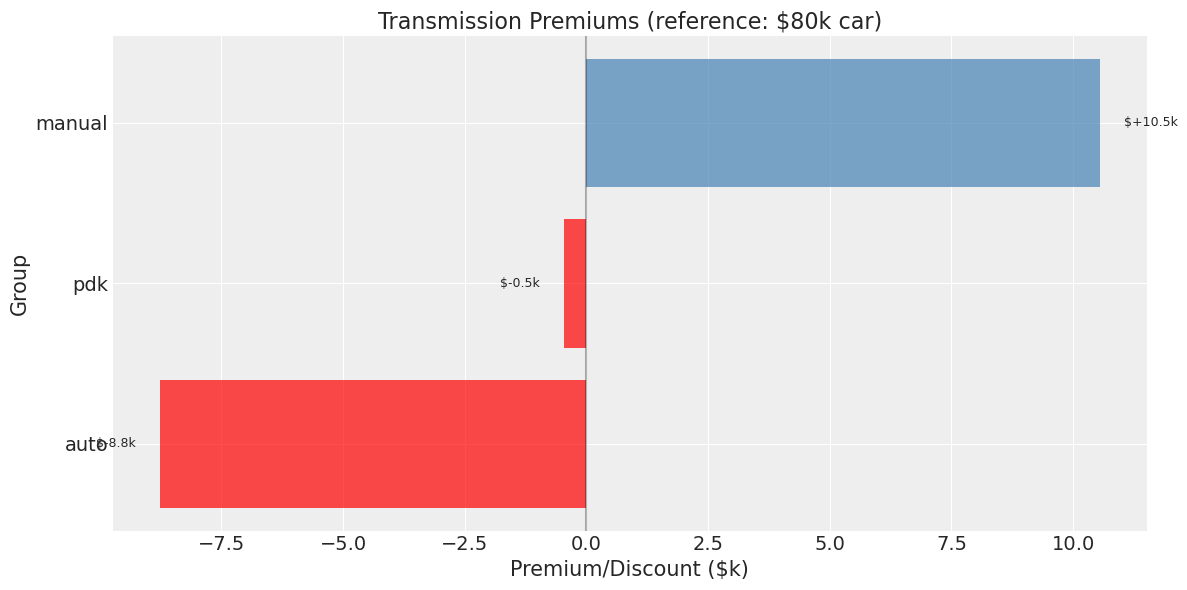

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:428: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


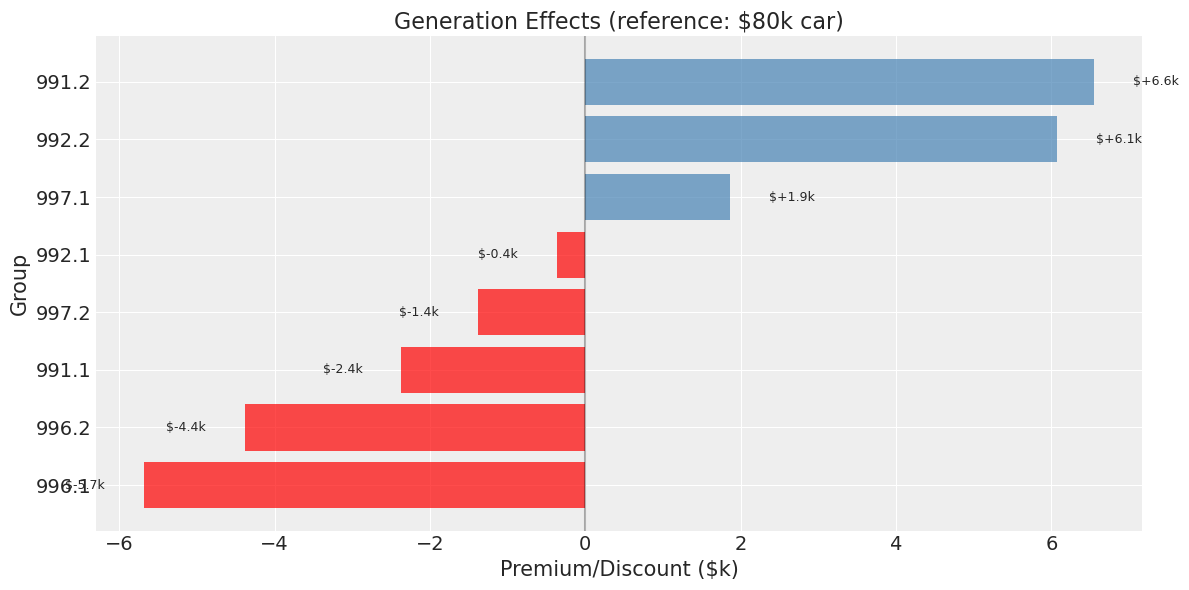

Premium Summary (at $80k reference price):

Trim Tier vs Base:
  sport: $+17,913 [$+15,198, $+20,828]
  turbo: $+79,587 [$+74,744, $+84,532]
  gt: $+81,743 [$+75,247, $+88,335]
  rs: $+183,047 [$+170,458, $+196,199]

Transmission vs PDK:
  Manual: $+11,058 [$+8,454, $+13,693]
  Auto:   $-8,376 [$-11,540, $-4,960]

Generation vs Grand Mean:
  996.2: $-2,171 [$-20,981, $+8,994]
  997.2: $-756 [$-13,530, $+11,607]
  991.1: $-1,308 [$-14,635, $+9,414]
  992.1: $-763 [$-8,569, $+11,347]


In [36]:
# Dollar premiums: convert log-scale effects to real dollars
# For a reference car at median price, compute the dollar difference

REFERENCE_PRICE = 80000  # Median price from EDA

# Extract mean effects for each group
trim_effects = []
for tier in ["base", "sport", "turbo", "gt", "rs"]:
    effect = idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": tier}).mean().item()
    trim_effects.append({"group": tier, "effect": effect})
trim_effects_df = pd.DataFrame(trim_effects)

trans_effects = []
for trans in ["auto", "pdk", "manual"]:
    effect = idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": trans}).mean().item()
    trans_effects.append({"group": trans, "effect": effect})
trans_effects_df = pd.DataFrame(trans_effects)

gen_effects = []
for gen in WATER_COOLED_GENS:
    effect = idata.posterior["1|generation"].sel({"generation__factor_dim": gen}).mean().item()
    gen_effects.append({"group": gen, "effect": effect})
gen_effects_df = pd.DataFrame(gen_effects)

# Create bar chart visualizations
fig1 = plot_dollar_premiums(
    trim_effects_df,
    REFERENCE_PRICE,
    title=f"Trim Tier Premiums (reference: ${REFERENCE_PRICE / 1000:.0f}k car)",
)
plt.show()

fig2 = plot_dollar_premiums(
    trans_effects_df,
    REFERENCE_PRICE,
    title=f"Transmission Premiums (reference: ${REFERENCE_PRICE / 1000:.0f}k car)",
)
plt.show()

fig3 = plot_dollar_premiums(
    gen_effects_df,
    REFERENCE_PRICE,
    title=f"Generation Effects (reference: ${REFERENCE_PRICE / 1000:.0f}k car)",
)
plt.show()

# Summary statistics with uncertainty
print(f"Premium Summary (at ${REFERENCE_PRICE / 1000:.0f}k reference price):")

print("\nTrim Tier vs Base:")
base_effect = idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": "base"}).values.flatten()
for tier in ["sport", "turbo", "gt", "rs"]:
    tier_effect = (
        idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": tier}).values.flatten()
    )
    premium = REFERENCE_PRICE * (np.exp(tier_effect - base_effect) - 1)
    print(
        f"  {tier}: ${np.median(premium):+,.0f} [${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
    )

print("\nTransmission vs PDK:")
pdk_effect = idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "pdk"}).values.flatten()
manual_effect = (
    idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "manual"}).values.flatten()
)
auto_effect = (
    idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "auto"}).values.flatten()
)
manual_premium = REFERENCE_PRICE * (np.exp(manual_effect - pdk_effect) - 1)
auto_discount = REFERENCE_PRICE * (np.exp(auto_effect - pdk_effect) - 1)
print(
    f"  Manual: ${np.median(manual_premium):+,.0f} [${np.percentile(manual_premium, 5):+,.0f}, ${np.percentile(manual_premium, 95):+,.0f}]"
)
print(
    f"  Auto:   ${np.median(auto_discount):+,.0f} [${np.percentile(auto_discount, 5):+,.0f}, ${np.percentile(auto_discount, 95):+,.0f}]"
)

print("\nGeneration vs Grand Mean:")
for gen in ["996.2", "997.2", "991.1", "992.1"]:
    gen_effect = (
        idata.posterior["1|generation"].sel({"generation__factor_dim": gen}).values.flatten()
    )
    premium = REFERENCE_PRICE * (np.exp(gen_effect) - 1)
    print(
        f"  {gen}: ${np.median(premium):+,.0f} [${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
    )

## Residual Analysis: Where is the Model Missing Information?

Cars selling above/below prediction likely have attributes the model doesn't capture:
- **Over prediction** (actual < predicted): Condition issues, undesirable options, salvage title
- **Under prediction** (actual > predicted): PTS colors, rare options, low production, exceptional condition

This helps identify what information we're missing, not necessarily "deals".

In [37]:
# Generate predictions for all observations
# Note: kind="response_params" replaces deprecated "mean"
model.predict(idata, data=df, kind="response_params", inplace=True)

# Extract posterior mean predictions (stored as 'mu' in posterior)
predicted_log_price = idata.posterior["mu"].mean(dim=["chain", "draw"]).values

# Create residual dataframe
df_resid = df.copy()
df_resid["predicted_log_price"] = predicted_log_price
df_resid["residual"] = df_resid["log_price"] - df_resid["predicted_log_price"]
df_resid["pct_diff"] = (np.exp(df_resid["residual"]) - 1) * 100  # % above/below prediction
df_resid["predicted_price"] = np.exp(df_resid["predicted_log_price"])

print(f"Residual summary:")
print(f"  Mean: {df_resid['residual'].mean():.4f} (should be ~0)")
print(f"  Std:  {df_resid['residual'].std():.4f}")
print(f"  Min:  {df_resid['residual'].min():.4f} ({df_resid['pct_diff'].min():.1f}%)")
print(f"  Max:  {df_resid['residual'].max():.4f} ({df_resid['pct_diff'].max():.1f}%)")

Residual summary:
  Mean: -0.0001 (should be ~0)
  Std:  0.1987
  Min:  -1.1064 (-66.9%)
  Max:  1.5080 (351.8%)


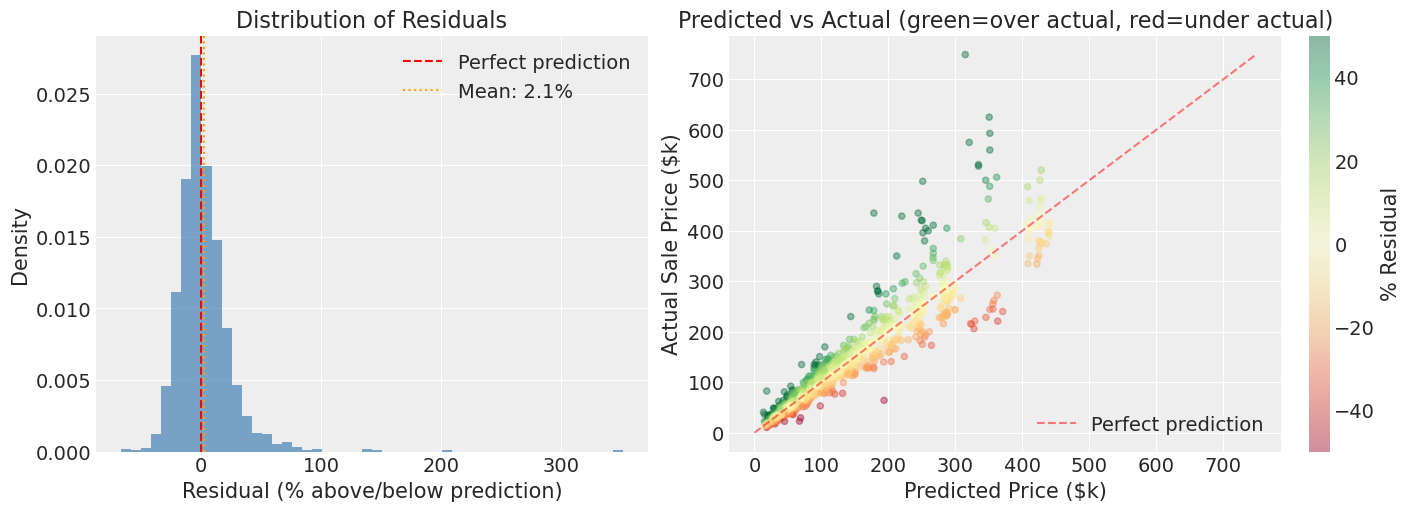

In [38]:
# Residual visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of residuals (should be ~normal)
ax = axes[0]
ax.hist(df_resid["pct_diff"], bins=50, alpha=0.7, density=True, color="steelblue")
ax.axvline(0, color="red", linestyle="--", label="Perfect prediction")
ax.axvline(
    df_resid["pct_diff"].mean(),
    color="orange",
    linestyle=":",
    label=f"Mean: {df_resid['pct_diff'].mean():.1f}%",
)
ax.set_xlabel("Residual (% above/below prediction)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Residuals")
ax.legend()

# Right: Predicted vs Actual scatter
ax = axes[1]
ax.scatter(
    df_resid["predicted_price"] / 1000,
    df_resid["sale_price"] / 1000,
    alpha=0.4,
    s=20,
    c=df_resid["pct_diff"],
    cmap="RdYlGn",
    vmin=-50,
    vmax=50,
)
# 1:1 line
max_price = max(df_resid["predicted_price"].max(), df_resid["sale_price"].max()) / 1000
ax.plot([0, max_price], [0, max_price], "r--", alpha=0.5, label="Perfect prediction")
ax.set_xlabel("Predicted Price ($k)")
ax.set_ylabel("Actual Sale Price ($k)")
ax.set_title("Predicted vs Actual (green=over actual, red=under actual)")
ax.legend()
plt.colorbar(ax.collections[0], ax=ax, label="% Residual")

# plt.tight_layout()
plt.show()

In [39]:
# Top outliers: what information is the model missing?

# Columns to display
display_cols = [
    "title_raw",
    "generation",
    "trim",
    "transmission",
    "mileage",
    "sale_price",
    "predicted_price",
    "pct_diff",
    "listing_url",
]


# Format for display
def format_outliers(df_out):
    df_display = df_out[display_cols].copy()
    df_display["sale_price"] = df_display["sale_price"].apply(lambda x: f"${x:,.0f}")
    df_display["predicted_price"] = df_display["predicted_price"].apply(lambda x: f"${x:,.0f}")
    df_display["pct_diff"] = df_display["pct_diff"].apply(lambda x: f"{x:+.1f}%")
    df_display["mileage"] = df_display["mileage"].apply(lambda x: f"{x:,.0f}")
    return df_display


print("=" * 80)
print("MODEL UNDER-PREDICTED (sold ABOVE prediction)")
print("Likely: PTS colors, rare options, low production, exceptional condition")
print("=" * 80)
top_under = df_resid.nlargest(10, "pct_diff")
display(format_outliers(top_under))

print("\n" + "=" * 80)
print("MODEL OVER-PREDICTED (sold BELOW prediction)")
print("Likely: Condition issues, undesirable options, salvage title, high-mile examples")
print("=" * 80)
top_over = df_resid.nsmallest(10, "pct_diff")
display(format_outliers(top_over))

MODEL UNDER-PREDICTED (sold ABOVE prediction)
Likely: PTS colors, rare options, low production, exceptional condition


,title_raw,generation,trim,transmission,mileage,sale_price,predicted_price,pct_diff,listing_url
329,Safari-Style 2001 Porsche 911 Carrera 4 Coupe ...,996.1,Carrera 4,Manual,"166,000","$82,500","$18,262",+351.8%,https://bringatrailer.com/listing/2001-porsche...
29,Modified 1999 Porsche 911 Carrera Coupe 6-Speed,996.1,Carrera,Manual,"208,000","$40,500","$13,417",+201.9%,https://bringatrailer.com/listing/1999-porsche...
1160,Jerry Seinfeld’s 2014 Porsche 911 50th Anniver...,991.1,Turbo S,PDK,"3,700","$435,000","$178,243",+144.0%,https://bringatrailer.com/listing/2014-porsche...
279,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,996.1,Carrera 4,Manual,"187,000","$35,911","$15,088",+138.0%,https://bringatrailer.com/listing/1999-porsche...
785,"4,000-Mile 2011 Porsche 911 GT3 RS 4.0",997.2,GT3 RS,Manual,"4,000","$749,000","$314,768",+138.0%,https://bringatrailer.com/listing/2011-porsche...
463,868-Mile 2007 Porsche 911 GT3 RS,997.1,GT3 RS,Manual,868,"$498,000","$251,195",+98.3%,https://bringatrailer.com/listing/2007-porsche...
964,2024 Porsche 911 Turbo S Cabriolet Brabus 820,992.2,Turbo S,PDK,"1,600","$429,000","$219,944",+95.1%,https://bringatrailer.com/listing/2024-porsche...
277,RWD-Converted 2003 Porsche 911 Carrera 4S Coup...,996.2,Carrera 4S,Manual,"1,400","$135,000","$70,380",+91.8%,https://bringatrailer.com/listing/2003-porsche...
806,RWB-Style 2009 Porsche 911 Carrera S Cabriolet,997.2,Carrera S,PDK,"87,000","$81,000","$44,617",+81.5%,https://bringatrailer.com/listing/2009-porsche...
517,683-Mile 2011 Porsche 911 GT3 RS,997.2,GT3 RS,Manual,683,"$575,000","$320,658",+79.3%,https://bringatrailer.com/listing/2011-porsche...



MODEL OVER-PREDICTED (sold BELOW prediction)
Likely: Condition issues, undesirable options, salvage title, high-mile examples


,title_raw,generation,trim,transmission,mileage,sale_price,predicted_price,pct_diff,listing_url
714,2011 Porsche 911 GT3 Cup,997.2,GT3,Manual,"4,000","$64,000","$193,492",-66.9%,https://bringatrailer.com/listing/2011-porsche...
418,4.0L-Powered 2009 Porsche 911 Carrera S Coupe ...,997.2,Carrera S,Manual,"65,000","$22,750","$67,210",-66.2%,https://bringatrailer.com/listing/2009-porsche...
693,2006 Porsche 911 Carrera S Coupe 6-Speed Race ...,997.1,Carrera S,Manual,"20,000","$29,500","$68,798",-57.1%,https://bringatrailer.com/listing/2006-porsche...
759,2011 Porsche 911 Carrera 4S Cabriolet,997.2,Carrera 4S,PDK,"95,000","$22,500","$44,866",-49.9%,https://bringatrailer.com/listing/2011-porsche...
40,1999 Porsche 911 GT3 Race Car,996.1,GT3,Manual,"7,000","$53,000","$98,313",-46.1%,https://bringatrailer.com/listing/1999-porsche...
45,2004 Porsche 911 Carrera 4S Cabriolet,996.2,Carrera 4S,Manual,"100,000","$17,250","$30,542",-43.5%,https://bringatrailer.com/listing/2004-porsche...
189,2001 Porsche 911 Carrera Cabriolet 6-Speed,996.1,Carrera,Manual,"138,000","$10,750","$18,247",-41.1%,https://bringatrailer.com/listing/2001-porsche...
1037,2014 Porsche 911 GT3,991.1,GT3,PDK,"26,000","$78,000","$131,524",-40.7%,https://bringatrailer.com/listing/2014-porsche...
1575,2019 Porsche 911 GT3 RS,991.2,GT3 RS,PDK,"6,000","$221,000","$363,264",-39.2%,https://bringatrailer.com/listing/2019-porsche...
574,2007 Porsche 911 Carrera 4S Coupe 6-Speed,997.1,Carrera 4S,Manual,"57,000","$36,000","$57,958",-37.9%,https://bringatrailer.com/listing/2007-porsche...


## Color Category Analysis

Test adding color_category as a random intercept to capture PTS and special color premiums.

In [40]:
# Color category distribution (after improved PTS detection)
print("Color category distribution:")
print(df_cleaned["color_category"].value_counts())
print()

# Price summary by color category
print("Price by color category:")
for cat in ["standard", "special", "PTS", "unknown"]:
    subset = df_cleaned[df_cleaned["color_category"] == cat]
    if len(subset) > 0:
        print(f"  {cat}: n={len(subset)}, median=${subset['sale_price'].median():,.0f}")

Color category distribution:
color_category
standard    1111
special      278
unknown      132
PTS           94
Name: count, dtype: int64

Price by color category:
  standard: n=1111, median=$71,911
  special: n=278, median=$134,000
  PTS: n=94, median=$291,502
  unknown: n=132, median=$45,125


In [41]:
# Build model WITH color_category
model_color = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
    include_color=True,  # NEW: add color as random intercept
)
print(model_color)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style) + (1 | color_category)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.5, sigma: 1.0)
            age ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x309c3c7c0>(sigma: 0.2)
            is_low_mileage ~ <function _truncated_normal_lower at 0x309c3c860>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 

In [42]:
# Fit model with color
idata_color = fit_model(
    model_color,
    draws=1000,
    tune=1000,
    chains=9,
    cores=9,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 9 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (9 chains in 9 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (9 chains in 9 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset, 1|color_category_sigma, 1|color_category_offset]


Output()

Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 129 seconds.
INFO:pymc.sampling.mcmc:Sampling 9 chains for 1_000 tune and 1_000 draw iterations (9_000 + 9_000 draws total) took 129 seconds.
INFO:price_analysis.models.hierarchical:Model summary:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma            0.197  0.004   0.190    0.204      0.000    0.000   15901.0   
Intercept       11.923  0.298  11.338   12.475      0.005    0.004    3536.0   
age             -0.028  0.009  -0.045   -0.010      0.000    0.000    3153.0   
mileage_scaled  -0.215  0.008  -0.229   -0.199      0.000    0.000   17167.0   
is_low_mileage   0.150  0.021   0.110    0.188      0.000    0.000   12502.0   

                ess_tail  r_hat  
sigma             6669.0    1.0  
Intercept         4832.0    1.0  
age               2477.0    1.0  
mileage_scaled    6408.0    1.0  
is_low_mileage    5744.0    1.0  


In [43]:
# Compare models: with vs without color
comparison_color = az.compare(
    {"with_color": idata_color, "without_color": idata},
    ic="loo",
    scale="log",
)
display(comparison_color.round(4))
print("\nPositive elpd_diff means 'with_color' has better predictive performance.")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_color,0,265.9926,29.7620,0.0000,0.9559,51.6500,0.0000,False,log
without_color,1,243.1111,27.0586,22.8814,0.0441,50.5698,7.3682,False,log



Positive elpd_diff means 'with_color' has better predictive performance.


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_76296/3256211530.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


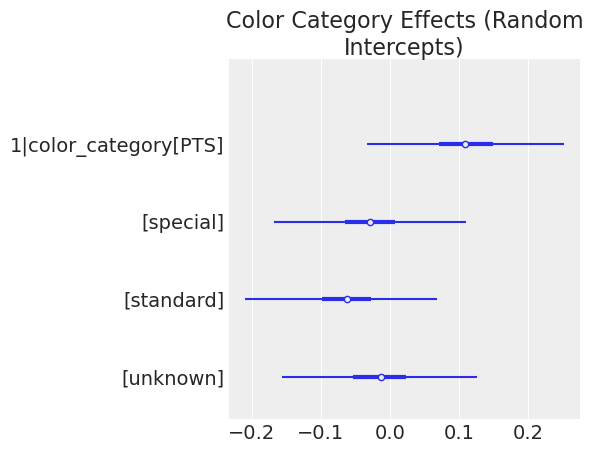


Color premiums (at $80k reference price):
  special vs standard: $+2,752 [$+653, $+4,789]
  PTS vs standard: $+15,184 [$+11,247, $+19,390]
  unknown vs standard: $+3,944 [$+684, $+7,358]


In [44]:
# Visualize color category effects
az.plot_forest(idata_color, var_names=["1|color_category"], combined=True)
plt.title("Color Category Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

# Extract color effects with uncertainty
REFERENCE_PRICE = 80000
print(f"\nColor premiums (at ${REFERENCE_PRICE / 1000:.0f}k reference price):")
std_effect = (
    idata_color.posterior["1|color_category"]
    .sel({"color_category__factor_dim": "standard"})
    .values.flatten()
)

for cat in ["special", "PTS", "unknown"]:
    cat_effect = (
        idata_color.posterior["1|color_category"]
        .sel({"color_category__factor_dim": cat})
        .values.flatten()
    )
    premium = REFERENCE_PRICE * (np.exp(cat_effect - std_effect) - 1)
    print(
        f"  {cat} vs standard: ${np.median(premium):+,.0f} "
        f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
    )